# 3 Body Modelling - 2D


Notebook for 3 body modelling calculations that are to be developed into N body calculations.

In [27]:
# Import requirements
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

In [313]:
# Function that will be passed into the ode to update
# spatial coordinates and velocites of 3 bodies

def ThreeBodyFunction(t, r):
    
    dr = np.zeros(12)
    
    # Abritrary value for G and the masses of the bodies. Masses setup to produce
    # elliptical orbits of 2 light bodies around a more massive one

    G = 1
    m1 = 1
    m2 = 1
    m3 = 3000
    
    xpos1 = r[0]
    xvel1 = r[1]
    ypos1 = r[2]
    yvel1 = r[3]
    xpos2 = r[4]
    xvel2 = r[5]
    ypos2 = r[6]
    yvel2 = r[7]
    xpos3 = r[8]
    xvel3 = r[9]
    ypos3 = r[10]
    yvel3 = r[11]
    
    # We need 3 equations for the distance between bodies as we need the
    # distance between 1 and 2, 1 and 3, and 2 and 3.

    r_12 = ((xpos1-xpos2)**2 + (ypos1-ypos2)**2)**0.5
    r_13 = ((xpos1-xpos3)**2 + (ypos1-ypos3)**2)**0.5
    r_23 = ((xpos2-xpos3)**2 + (ypos2-ypos3)**2)**0.5

    # Set of coupled differential equations for ode to solve

    dxpos1 = xvel1
    dr[0] = dxpos1

    dxvel1 =  (-G*m2*(xpos1-xpos2))*(r_12)**(-3) + (-G*m3*(xpos1-xpos3))*(r_13)**(-3)
        
    dr[1] = dxvel1

    dypos1 = yvel1
    dr[2] = dypos1

    dyvel1 = (-G*m2*(ypos1-ypos2))*(r_12)**(-3) + \
        (-G*m3*(ypos1-ypos3))*(r_13)**(-3)
    dr[3] = dyvel1

    dxpos2 = xvel2
    dr[4] = dxpos2

    dxvel2 = (-G*m1*(xpos2-xpos1))*(r_12)**(-3) + \
        (-G*m3*(xpos2-xpos3))*(r_23)**(-3)
    dr[5] = dxvel2

    dypos2 = yvel2
    dr[6] = dypos2

    dyvel2 = (-G*m1*(ypos2-ypos1))*(r_12)**(-3) + \
        (-G*m3*(ypos2-ypos3))*(r_23)**(-3)
    dr[7] = dyvel2

    dxpos3 = xvel3
    dr[8] = dxpos3

    dxvel3 = (-G*m1*(xpos3-xpos1))*(r_13)**(-3) + \
        (-G*m2*(xpos3-xpos2))*(r_23)**(-3)
    dr[9] = dxvel3

    dypos3 = yvel3
    dr[10] = dypos3

    dyvel3 = (-G*m1*(ypos3-ypos1))*(r_13)**(-3) + \
        (-G*m2*(ypos3-ypos2))*(r_23)**(-3)
    dr[11] = dyvel3
        
    return dr

In [312]:
class Body:
    
    def __init__(self, x, vx, y, vy, mass, name):
        
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.mass = mass
        self.name = name

In [399]:
def NBodyFunc(t, posVelArray, bodies):
    
    # posVelArray = [body1_x, body1_vx, body1_y, body1_vy, body2_x, ...]
    
    # Set up array to store updated spatial and velocity values
    dposVelArray = np.zeros(4 * len(bodies))
        
    # Arbritrary value for G (gravitational constant)
    G = 1
    
    # Change in x, y is velocity in x, y
    dposVelArray[0:len(dposVelArray):4] = posVelArray[1:len(posVelArray):4]
    dposVelArray[2:len(dposVelArray):4] = posVelArray[3:len(posVelArray):4]
    
    # Loop through bodies, calculating change in vx, vy
    # due to all other bodies
    for i, body in enumerate(bodies):
                        
        # Extract x, y values of body
        xposBody = posVelArray[i*4]
        yposBody = posVelArray[i*4 + 2]
        
        dxvelBody = 0
        dyvelBody = 0
        
        for j, otherBody in enumerate(bodies):
            
            # Check bodies aren't the same
            if i != j:
                
                # Extract x, y & mass of other body
                xposOtherBody = posVelArray[j*4]
                yposOtherBody = posVelArray[j*4 + 2]
                massOtherBody = otherBody.mass
                
                # Distance
                r = ((xposBody-xposOtherBody)**2 + (yposBody-yposOtherBody)**2)**0.5
                
                # Change in vx, vy
                dxvelBody +=  (-G*massOtherBody*(xposBody-xposOtherBody))*(r)**(-3)
                dyvelBody +=  (-G*massOtherBody*(yposBody-yposOtherBody))*(r)**(-3)
        
        # Add resultant change in vel to array
        dposVelArray[i*4 + 1] = dxvelBody
        dposVelArray[i*4 + 3] = dyvelBody
                
            
    return dposVelArray


In [428]:
# Conditions for 2 light bodies orbiting a more massive one
body1 = Body(50, 0, 0, 10, 1, 'body1')
body2 = Body(-50, 0, 0, -10, 1, 'body2')
body3 = Body(0, 0, 0, 0, 3000, 'body3')

bodies = [body1, body2, body3]

In [429]:
initial = []

# Loop through bodies and create inital conditions to be passed
# into the integrator below
for body in bodies:
    values = [body.x, body.vx, body.y, body.vy]
    initial += values
    
print(initial)

[50, 0, 0, 10, -50, 0, 0, -10, 0, 0, 0, 0]


In [439]:
# Setup time interval and steps to iterate over
t0 = 0
t1 = 210.75
t = np.linspace(t0, t1, 1000)

In [440]:
# Array for solution
y = np.zeros((len(t), len(bodies*4)))
y[0, :] = initial

# Setup integrator
r = integrate.ode(NBodyFunc) \
        .set_integrator('dop853', rtol=1e-6, atol=1e-10) \
        .set_initial_value(initial, t0).set_f_params(bodies)

# Iterate over time intervals and integrate
for i in range(1, t.size):
    # Store updated spatial coordinates and velocities of bodies
    y[i, :] = r.integrate(t[i])

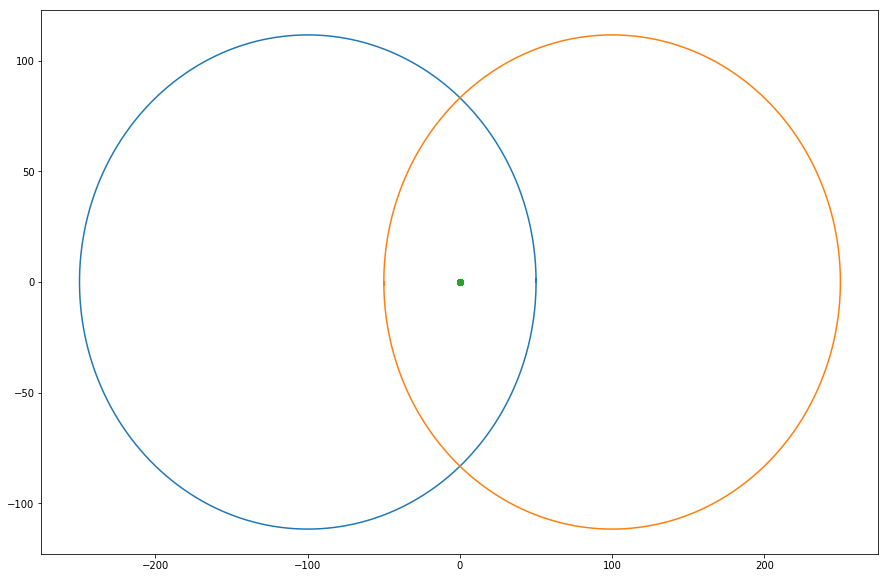

In [441]:
# Plot results
plt.figure(figsize=(15,10))
plt.plot(y[:, 0], y[:, 2])
plt.plot(y[:, 4], y[:, 6])
plt.plot(y[:, 8], y[:, 10], 'o')
plt.show()